# Unit15_Example | Fuel Gas Emission：以 DNN 預測 NOx 排放（回歸）

本 Notebook 使用 `Part_4/data/fuel_gas/train.csv` 建立回歸型 DNN（MLP）模型來預測 `NOX`。

## 目標
- 建立 baseline（Ridge）與 DNN 的效果對照
- 示範正確資料切分與標準化（避免 data leakage）
- 以 MAE / RMSE / R2 評估模型
- 產生 `test.csv` 的推論結果並保存模型

資料背景可參考 Kaggle：https://www.kaggle.com/datasets/sjagkoo7/fuel-gas-emission/data


---
## 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P4_Unit15_Example_FuelGasEmission'
SOURCE_DATA_DIR = 'fuel_gas'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_4'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")


# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_4
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_4\data\fuel_gas
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit15_Example_FuelGasEmission
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit15_Example_FuelGasEmission\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit15_Example_FuelGasEmission\figs

TensorFlow Version: 2.10.0
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


## 數據下載

In [2]:
# 數據來源: Kaggle Red Wine Quality Dataset
# https://www.kaggle.com/api/v1/datasets/download/sjagkoo7/fuel-gas-emission

import requests
import os
import zipfile

# 1. 設定路徑與 URL
url = "https://www.kaggle.com/api/v1/datasets/download/sjagkoo7/fuel-gas-emission"
zip_path = os.path.join(DATA_DIR, "fuel-gas-emission.zip")
data_file = os.path.join(DATA_DIR, "train.csv")
extract_path = DATA_DIR

def download_and_extract():
    # --- 步驟 A: 下載檔案 ---
    print(f"正在從 {url} 下載...")
    try:
        # allow_redirects=True 處理 Kaggle 的重導向
        response = requests.get(url, allow_redirects=True, stream=True)
        response.raise_for_status() # 若下載失敗會拋出異常
        
        with open(zip_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"下載成功，檔案儲存於: {zip_path}")

        # --- 步驟 B: 解壓縮檔案 ---
        if zipfile.is_zipfile(zip_path):
            print(f"正在解壓縮至: {extract_path}...")
            # 確保目標資料夾存在
            if not os.path.exists(extract_path):
                os.makedirs(extract_path)
            
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            
            print("解壓縮完成！")
            
            # (選填) 步驟 C: 刪除原始 ZIP 檔以節省空間
            # os.remove(zip_path)
            # print("已移除原始 ZIP 壓縮檔。")
        else:
            print("錯誤：下載的檔案不是有效的 ZIP 格式。")
            
    except Exception as e:
        print(f"發生錯誤: {e}")

if __name__ == "__main__" and not os.path.exists(data_file):
    download_and_extract()
else:
    print(f"檔案已存在於: {data_file}")

檔案已存在於: d:\MyGit\CHE-AI-COURSE\Part_4\data\fuel_gas\train.csv


## 載入模組

In [3]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import joblib, pickle, json
import warnings
warnings.filterwarnings('ignore')

# sklearn套件
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

print(f"TensorFlow版本: {tf.__version__}")
print(f"Keras版本: {keras.__version__}")

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(seed=None)
tf.random.set_seed(seed=None)

# 設定matplotlib中文顯示
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial'] # Colab不支援
plt.rcParams['axes.unicode_minus'] = False

TensorFlow版本: 2.10.0
Keras版本: 2.10.0


---
## 1) 讀取資料與快速檢查

- `train.csv`：包含 10 個特徵欄位 + 目標 `NOX`
- `test.csv`：只包含 10 個特徵欄位（用於推論示範）


In [4]:
df_train = pd.read_csv(DATA_DIR / "train.csv")
df_test = pd.read_csv(DATA_DIR / "test.csv")

print("train:", df_train.shape)
print("test :", df_test.shape)
display(df_train.head())

print("\nMissing values (train):")
display(df_train.isna().sum())

print("\nTarget (NOX) summary:")
display(df_train["NOX"].describe())


train: (5187, 11)
test : (2224, 10)


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,12.728,1007.8,87.949,4.4928,24.333,1086.3,550.02,134.41,11.838,0.95374,74.117
1,24.577,1011.4,47.300,2.9115,18.739,1051.0,549.94,104.80,10.141,2.54190,61.887
2,14.084,1017.6,73.675,2.9318,19.350,1057.5,550.03,112.21,10.535,3.90110,75.568
3,32.422,1011.0,52.727,4.5852,29.825,1099.6,540.82,146.50,13.279,0.35179,52.580
4,13.788,1016.8,86.933,3.5058,24.090,1085.8,550.03,133.33,11.775,1.73960,69.873



Missing values (train):


AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64


Target (NOX) summary:


count    5187.000000
mean       67.655454
std        10.767665
min        27.765000
25%        60.371000
50%        65.704000
75%        74.445500
max       119.320000
Name: NOX, dtype: float64

---
## 2) EDA：相關性（簡易）

只做快速檢查：觀察 `NOX` 與各特徵的線性相關係數，幫助建立直覺（不代表因果）。


NOX     1.000000
CO      0.398577
AP      0.397132
AH      0.204171
TAT     0.081853
AFDP   -0.029571
TEY    -0.121759
CDP    -0.194726
TIT    -0.227484
GTEP   -0.244853
AT     -0.652353
Name: NOX, dtype: float64

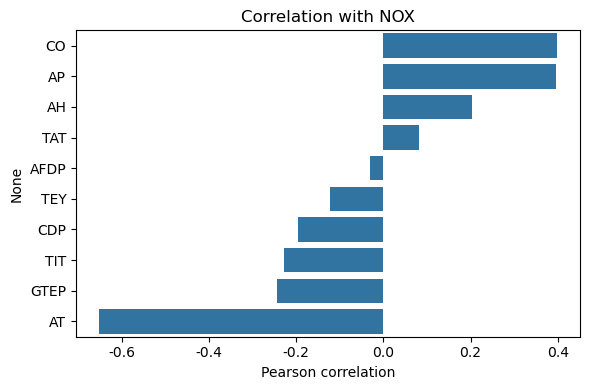

In [5]:
corr = df_train.corr(numeric_only=True)["NOX"].sort_values(ascending=False)
display(corr)

plt.figure(figsize=(6, 4))
sns.barplot(x=corr.drop("NOX").values, y=corr.drop("NOX").index, orient="h")
plt.title("Correlation with NOX")
plt.xlabel("Pearson correlation")
plt.tight_layout()
plt.savefig(FIG_DIR / "corr_bar.png")
plt.show()


---
## 3) 資料切分與標準化（避免 Data Leakage）

流程：
1. 從 `train.csv` 分離 `X` 與 `y`（`NOX`）
2. 切分成 train/valid/test
3. `StandardScaler` 僅使用訓練集 `fit`，再對 valid/test 做 `transform`


In [6]:
target_col = "NOX"
feature_cols = [c for c in df_train.columns if c != target_col]

X = df_train[feature_cols].to_numpy(dtype=np.float32)
y = df_train[target_col].to_numpy(dtype=np.float32)

# train : valid : test = 70% : 15% : 15%
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, random_state=SEED
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=SEED
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)
X_test_s = scaler.transform(X_test)

print("X_train:", X_train_s.shape)
print("X_valid:", X_valid_s.shape)
print("X_test :", X_test_s.shape)


X_train: (3630, 10)
X_valid: (778, 10)
X_test : (779, 10)


---
## 4) Baseline：Ridge Regression

建立一個快速 baseline，作為 DNN 是否值得的比較基準。


In [7]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_s, y_train)
pred_ridge = ridge.predict(X_test_s)

mae_r = float(mean_absolute_error(y_test, pred_ridge))
rmse_r = float(np.sqrt(mean_squared_error(y_test, pred_ridge)))
r2_r = float(r2_score(y_test, pred_ridge))

print(f"Ridge  MAE : {mae_r:.3f}")
print(f"Ridge RMSE : {rmse_r:.3f}")
print(f"Ridge R2  : {r2_r:.3f}")


Ridge  MAE : 3.622
Ridge RMSE : 5.620
Ridge R2  : 0.714


---
## 5) DNN（MLP）回歸模型

重點：
- 多層 Dense（全連接）
- BatchNorm + Dropout 增加訓練穩定度、降低過擬合
- EarlyStopping / ReduceLROnPlateau 協助收斂


In [9]:
# 建立模型
model = Sequential(
    [
        Input(shape=(X_train_s.shape[1],)),
        Dense(128, activation="relu"),
        #BatchNormalization(),
        #Dropout(0.20),
        Dense(64, activation="relu"),
        #BatchNormalization(),
        #Dropout(0.20),
        Dense(32, activation="relu"),
        Dense(1),
    ]
)

# 編譯模型
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"],
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               1408      
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,777
Trainable params: 11,777
Non-trainable params: 0
_________________________________________________________________


In [10]:
callbacks = [
    EarlyStopping(
        monitor="val_loss", patience=30, restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss", patience=10, factor=0.5, min_lr=1e-6
    ),
]

history = model.fit(
    X_train_s,
    y_train,
    validation_data=(X_valid_s, y_valid),
    epochs=500,
    batch_size=64,
    callbacks=callbacks,
    verbose=1,
)


Epoch 1/500
57/57 [==============================] - 1s 8ms/step - loss: 3754.0947 - mae: 59.5686 - val_loss: 1655.7097 - val_mae: 37.0036 - lr: 0.0010
Epoch 2/500
57/57 [==============================] - 0s 5ms/step - loss: 596.6434 - mae: 19.9313 - val_loss: 179.8434 - val_mae: 10.9081 - lr: 0.0010
Epoch 3/500
57/57 [==============================] - 0s 4ms/step - loss: 144.9893 - mae: 9.1981 - val_loss: 112.0822 - val_mae: 8.3483 - lr: 0.0010
Epoch 4/500
57/57 [==============================] - 0s 4ms/step - loss: 105.6323 - mae: 7.6034 - val_loss: 83.7089 - val_mae: 7.0561 - lr: 0.0010
Epoch 5/500
57/57 [==============================] - 0s 4ms/step - loss: 83.9527 - mae: 6.6320 - val_loss: 64.3569 - val_mae: 6.1117 - lr: 0.0010
Epoch 6/500
57/57 [==============================] - 0s 4ms/step - loss: 68.8286 - mae: 5.8297 - val_loss: 53.0451 - val_mae: 5.3465 - lr: 0.0010
Epoch 7/500
57/57 [==============================] - 0s 5ms/step - loss: 58.8346 - mae: 5.2630 - val_loss: 45.1

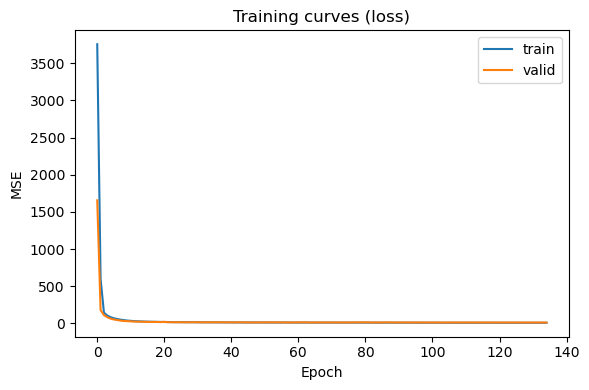

In [11]:

hist = pd.DataFrame(history.history)
plt.figure(figsize=(6, 4))
plt.plot(hist["loss"], label="train")
plt.plot(hist["val_loss"], label="valid")
plt.title("Training curves (loss)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "loss_curve.png")
plt.show()


---
## 6) 評估：MAE / RMSE / R2 + Parity plot


In [13]:

pred_dnn = model.predict(X_test_s, verbose=0).reshape(-1)


mae = float(mean_absolute_error(y_test, pred_dnn))
rmse = float(np.sqrt(mean_squared_error(y_test, pred_dnn)))
r2 = float(r2_score(y_test, pred_dnn))

print(f"DNN   MAE : {mae:.3f}")
print(f"DNN  RMSE : {rmse:.3f}")
print(f"DNN   R2  : {r2:.3f}")

print()
print("(比較) Ridge baseline")
print(f"Ridge MAE : {mae_r:.3f}")
print(f"Ridge RMSE: {rmse_r:.3f}")
print(f"Ridge R2  : {r2_r:.3f}")

metrics = {
    "backend": "tensorflow/keras",
    "n_train": int(X_train_s.shape[0]),
    "n_valid": int(X_valid_s.shape[0]),
    "n_test": int(X_test_s.shape[0]),
    "ridge": {"mae": float(mae_r), "rmse": float(rmse_r), "r2": float(r2_r)},
    "dnn": {"mae": float(mae), "rmse": float(rmse), "r2": float(r2)},
}

metrics_path = OUTPUT_DIR / "metrics.json"
metrics_path.write_text(json.dumps(metrics, ensure_ascii=False, indent=2), encoding="utf-8")
print()
print("Saved metrics:", metrics_path)


DNN   MAE : 2.054
DNN  RMSE : 3.134
DNN   R2  : 0.911

(比較) Ridge baseline
Ridge MAE : 3.622
Ridge RMSE: 5.620
Ridge R2  : 0.714

Saved metrics: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit15_Example_FuelGasEmission\metrics.json


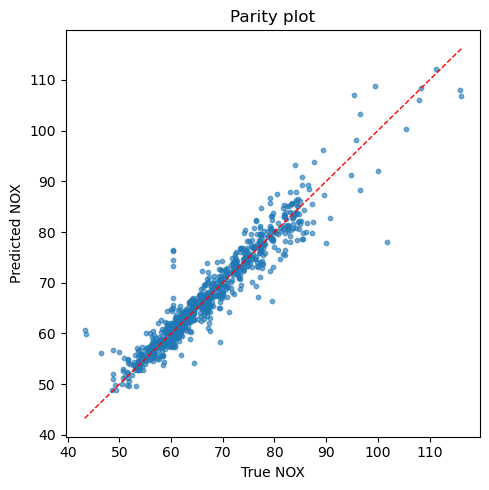

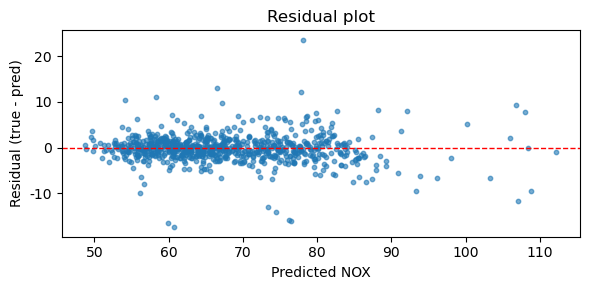

In [15]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, pred_dnn, s=10, alpha=0.6)

min_v = float(min(y_test.min(), pred_dnn.min()))
max_v = float(max(y_test.max(), pred_dnn.max()))
plt.plot([min_v, max_v], [min_v, max_v], "r--", linewidth=1)

plt.xlabel("True NOX")
plt.ylabel("Predicted NOX")
plt.title("Parity plot")
plt.tight_layout()
plt.savefig(FIG_DIR /"parity_plot.png")
plt.show()

residual = y_test - pred_dnn
plt.figure(figsize=(6, 3))
plt.scatter(pred_dnn, residual, s=10, alpha=0.6)
plt.axhline(0, color="r", linestyle="--", linewidth=1)
plt.xlabel("Predicted NOX")
plt.ylabel("Residual (true - pred)")
plt.title("Residual plot")
plt.tight_layout()
plt.savefig(FIG_DIR / "residual_plot.png")
plt.show()


---
## 7) 保存模型與推論 `test.csv`

- 保存：`outputs/P4_Unit15_Example_FuelGasEmission/models/`
- 產生 `test.csv` 的 NOX 預測：`outputs/P4_Unit15_Example_FuelGasEmission/nox_predictions_test.csv`


In [16]:
model_path = MODEL_DIR / "nox_dnn.keras"
model.save(model_path)
print("Saved model:", model_path)

scaler_path = MODEL_DIR / "scaler.joblib"
joblib.dump(scaler, scaler_path)
print("Saved scaler:", scaler_path)

X_kaggle = df_test[feature_cols].to_numpy(dtype=np.float32)
X_kaggle_s = scaler.transform(X_kaggle)
pred_kaggle = model.predict(X_kaggle_s, verbose=0).reshape(-1)
pred_path = OUTPUT_DIR / "nox_predictions_test.csv"
pd.DataFrame({"NOX": pred_kaggle}).to_csv(pred_path, index=False)
print("Saved predictions:", pred_path)

display(pd.read_csv(pred_path).head())


Saved model: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit15_Example_FuelGasEmission\models\nox_dnn.keras
Saved scaler: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit15_Example_FuelGasEmission\models\scaler.joblib
Saved predictions: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit15_Example_FuelGasEmission\nox_predictions_test.csv


,NOX
0,53.03721
1,71.37616
2,65.63416
3,83.51440
4,75.18087


---
## 8) test.csv（推論）

test.csv 不含目標欄位 NOX，需使用訓練好的模型與 scaler 產生 NOX 預測，並將結果儲存於 outputs/.../nox_predictions_test.csv。預測結果會合併至原始 test 特徵（欄位如 NOX_pred）以便後續分析與視覺化。

- test.csv：10 個特徵欄位（與 train 相同），不包含 NOX  
- 流程：載入 scaler -> 對 test 特徵做 transform -> 使用模型 predict -> 儲存預測結果  
- 建議檢查：train NOX 與 test 預測 NOX 的分布比較；NOX_pred 與關鍵特徵（例如 AT、CO）之散佈圖


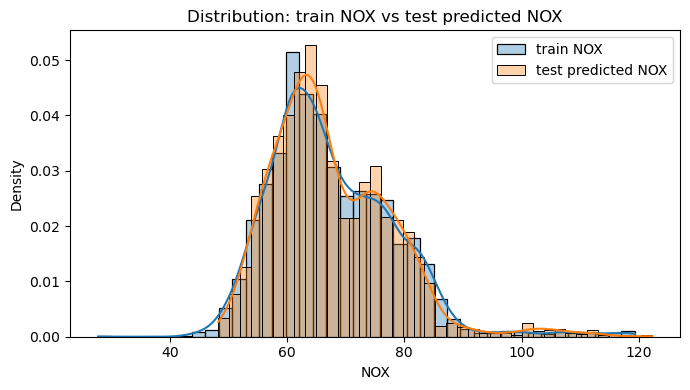

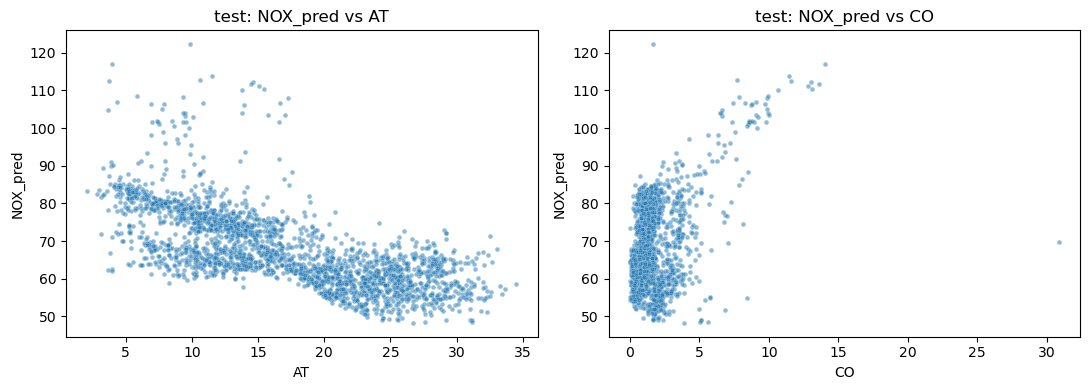

In [18]:
# 讀取預測結果
pred_df = pd.read_csv(pred_path)

plt.figure(figsize=(7, 4))
sns.histplot(df_train["NOX"], bins=40, stat="density", kde=True, color="C0", label="train NOX", alpha=0.35)
sns.histplot(pred_df["NOX"], bins=40, stat="density", kde=True, color="C1", label="test predicted NOX", alpha=0.35)
plt.title("Distribution: train NOX vs test predicted NOX")
plt.xlabel("NOX")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "test_pred_vs_train_dist.png")
plt.show()

# 將 test 特徵與預測值合併，便於視覺化
viz_df = df_test.copy()
viz_df["NOX_pred"] = pred_df["NOX"].to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
sns.scatterplot(data=viz_df, x="AT", y="NOX_pred", s=12, alpha=0.5, ax=axes[0])
axes[0].set_title("test: NOX_pred vs AT")
axes[0].set_xlabel("AT")
axes[0].set_ylabel("NOX_pred")

sns.scatterplot(data=viz_df, x="CO", y="NOX_pred", s=12, alpha=0.5, ax=axes[1])
axes[1].set_title("test: NOX_pred vs CO")
axes[1].set_xlabel("CO")
axes[1].set_ylabel("NOX_pred")

plt.tight_layout()
plt.savefig(FIG_DIR / "test_pred_scatter.png")
plt.show()
